# Fine-Tuning P.1203 Model

# ITU-T P.1203

In [44]:
import matplotlib.pyplot as plt
import pandas as pd
from itu_p1203_new import P1203Standalone
from itu_p1203_new import P1203Pq
from itu_p1203_new import P1203Pa
from itu_p1203_new import P1203Pv
from itertools import permutations

import json


In [45]:
f = open("./mode0.json")
input_data = json.load(f)
input_data

{'I11': {'segments': [], 'streamId': 42},
 'I13': {'segments': [{'bitrate': 691.72,
    'codec': 'h264',
    'start': 0,
    'duration': 20,
    'fps': 25.0,
    'resolution': '1920x1080'}],
  'streamId': 42},
 'I23': {'stalling': [], 'streamId': 42},
 'IGen': {'device': 'pc',
  'displaySize': '1920x1080',
  'viewingDistance': '200cm'}}

In [46]:
bitratesMbps = {
    'BlueSpin': {'r01': 1.75, 'r02': 2.29, 'r03': 3.17, 'r04': 7.53, 'r05': 12.62},
    'CasualSquat':  {'r01': 2.50, 'r02': 3.91, 'r03': 6.66, 'r04': 19.51, 'r05': 31.11},
    'ReadyForWinter':  {'r01': 1.97, 'r02': 2.58, 'r03': 3.61, 'r04': 9.34, 'r05': 16.59},
    'FlowerDance':  {'r01': 2.66, 'r02': 4.24, 'r03': 7.12, 'r04': 22.81, 'r05': 39.35},
}

resolution_map = {
    'r01': '640x360', # worse than 420p
    'r02': '852x480', # exactly 480p
    'r03': '1192x672', # bit worse than 720p
    'r04': '1533x864', # a bit better than 720p
    'r05': '1920x1080', # exactly 1080p

}

In [47]:
p1203_results = {
    'object': [],
    'qual': [],
    'bitrate': [],
    'p1203_qoe': []
}

for video in list(bitratesMbps.keys()):
    bitrates = list(bitratesMbps[video].values())
    qualities = list(bitratesMbps[video].keys())
    
    for bitrate, quality in zip(bitrates, qualities):
        p1203_results['object'].append(video)
        p1203_results['qual'].append(quality)
        p1203_results['bitrate'].append(bitrate)

        input_data['I13']['segments'][0]['bitrate'] = bitrate
        input_data['I13']['segments'][0]['resolution'] = resolution_map[quality]
        # print(input_data)
        p1203_results['p1203_qoe'].append(P1203Standalone(input_data).calculate_complete()['O46'])

# p1203_results

In [48]:
p1203_df = pd.DataFrame.from_dict(p1203_results)
p1203_df

,object,qual,bitrate,p1203_qoe
0,BlueSpin,r01,1.75,1.928742
1,BlueSpin,r02,2.29,1.944007
2,BlueSpin,r03,3.17,2.282241
3,BlueSpin,r04,7.53,3.256525
4,BlueSpin,r05,12.62,3.820975
5,CasualSquat,r01,2.50,1.928742
6,CasualSquat,r02,3.91,2.027952
7,CasualSquat,r03,6.66,2.710296
8,CasualSquat,r04,19.51,3.758302
9,CasualSquat,r05,31.11,4.271038


In [49]:
p1203_df_1 = p1203_df.loc[p1203_df['object'].isin(['BlueSpin', 'CasualSquat'])]
grouped_p1203_qoe = p1203_df_1.groupby(['object', 'qual'])
grouped_p1203_qoe = grouped_p1203_qoe.mean()
grouped_p1203_qoe


bitrate  p1203_qoe
object      qual                    
BlueSpin    r01      1.75   1.928742
            r02      2.29   1.944007
            r03      3.17   2.282241
            r04      7.53   3.256525
            r05     12.62   3.820975
CasualSquat r01      2.50   1.928742
            r02      3.91   2.027952
            r03      6.66   2.710296
            r04     19.51   3.758302
            r05     31.11   4.271038

In [50]:
p1203_qoe = list(grouped_p1203_qoe['p1203_qoe'])
p1203_qoe

[1.9287417775102607,
 1.9440068212513932,
 2.2822409311848038,
 3.2565251454064335,
 3.820974595850359,
 1.9287417775102607,
 2.027952374017254,
 2.7102963047151962,
 3.758301583946726,
 4.271037771214015]

In [51]:
import pandas as pd
import numpy as np
# get input data
ground_truth_df = pd.read_csv('./results/new-tests/individual_opinion_score_vpcc.csv')
ground_truth_df

,ID,objects,rate
0,1,BlueSpin_VPCC_r01_d200,1
1,1,FlowerDance_VPCC_r03_d200,2
2,1,ReadyForWinter_VPCC_r03_d200,3
3,1,BlueSpin_VPCC_r05_d200,3
4,1,ReadyForWinter_VPCC_r05_d200,3
...,...,...,...
815,41,FlowerDance_VPCC_r01_d200,2
816,41,BlueSpin_VPCC_r01_d200,2
817,41,BlueSpin_VPCC_r02_d200,2
818,41,ReadyForWinter_VPCC_r03_d200,4


In [52]:
ground_truth_df[['object', 'encoder', 'qual', 'dist']] = ground_truth_df.objects.str.split('_', expand=True)
#df['object'] = df['object'].str.lower()
ground_truth_df['rate_scaled'] = ground_truth_df['rate'] # no need to scale it since this time we took 1-5 results
ground_truth_df

,ID,objects,rate,object,encoder,qual,dist,rate_scaled
0,1,BlueSpin_VPCC_r01_d200,1,BlueSpin,VPCC,r01,d200,1
1,1,FlowerDance_VPCC_r03_d200,2,FlowerDance,VPCC,r03,d200,2
2,1,ReadyForWinter_VPCC_r03_d200,3,ReadyForWinter,VPCC,r03,d200,3
3,1,BlueSpin_VPCC_r05_d200,3,BlueSpin,VPCC,r05,d200,3
4,1,ReadyForWinter_VPCC_r05_d200,3,ReadyForWinter,VPCC,r05,d200,3
...,...,...,...,...,...,...,...,...
815,41,FlowerDance_VPCC_r01_d200,2,FlowerDance,VPCC,r01,d200,2
816,41,BlueSpin_VPCC_r01_d200,2,BlueSpin,VPCC,r01,d200,2
817,41,BlueSpin_VPCC_r02_d200,2,BlueSpin,VPCC,r02,d200,2
818,41,ReadyForWinter_VPCC_r03_d200,4,ReadyForWinter,VPCC,r03,d200,4


In [53]:
ground_truth_df = ground_truth_df.loc[ground_truth_df['object'].isin(['BlueSpin', 'CasualSquat'])]
grouped_ground_truth = ground_truth_df.groupby(['object', 'qual'])
grouped_ground_truth = grouped_ground_truth.mean(numeric_only=True)

In [54]:
qoe_ground_truth = list(grouped_ground_truth['rate'])
qoe_ground_truth

[1.4390243902439024,
 2.097560975609756,
 2.658536585365854,
 3.268292682926829,
 3.341463414634146,
 1.853658536585366,
 2.5853658536585367,
 2.7804878048780486,
 3.4146341463414633,
 3.6097560975609757]

Text(0, 0.5, 'P1203 Mode 0')

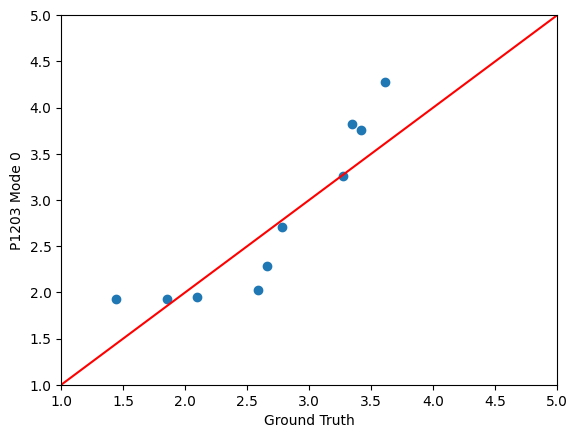

In [55]:
plt.scatter(qoe_ground_truth, p1203_qoe)
plt.plot([1, 5], [1, 5], color = 'red')
plt.axis([1, 5, 1, 5])
plt.xlabel("Ground Truth")
plt.ylabel("P1203 Mode 0")

Spearmann
              Ground truth    P.1203
Ground truth      1.000000  0.984807
P.1203            0.984807  1.000000


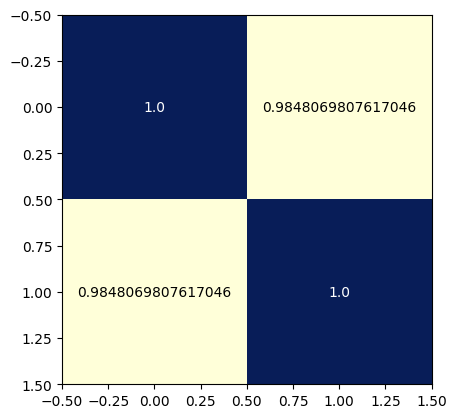

Pearson
              Ground truth    P.1203
Ground truth      1.000000  0.904858
P.1203            0.904858  1.000000


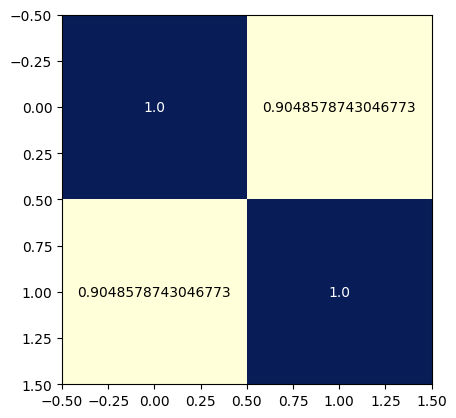

In [56]:
#import seaborn as sns
df_correlation = pd.DataFrame({'Ground truth': qoe_ground_truth,
                              'P.1203': p1203_qoe})

spear_corr = df_correlation.corr(method = 'spearman') #pearson
print("Spearmann")
print(spear_corr)

#sns.heatmap(corr, cmap='YlGnBu', annot = True)
plt.imshow(spear_corr, cmap='YlGnBu')

plt.text(0, 0, spear_corr['Ground truth']['Ground truth'], ha = "center", va = "center", color = "w")
plt.text(1, 0, spear_corr['Ground truth']['P.1203'], ha = "center", va = "center", color = "black")
plt.text(0, 1, spear_corr['P.1203']['Ground truth'], ha = "center", va = "center", color = "black")
plt.text(1, 1, spear_corr['P.1203']['P.1203'], ha = "center", va = "center", color = "w")

plt.savefig("./figures/correlation_spearman_1203_1080p.pdf")
plt.show()

pearson_corr = df_correlation.corr(method = 'pearson') #spearman
print("Pearson")
print(pearson_corr)

#sns.heatmap(corr, cmap='YlGnBu', annot = True)
plt.imshow(pearson_corr, cmap='YlGnBu')

plt.text(0, 0, pearson_corr['Ground truth']['Ground truth'], ha = "center", va = "center", color = "w")
plt.text(1, 0, pearson_corr['Ground truth']['P.1203'], ha = "center", va = "center", color = "black")
plt.text(0, 1, pearson_corr['P.1203']['Ground truth'], ha = "center", va = "center", color = "black")
plt.text(1, 1, pearson_corr['P.1203']['P.1203'], ha = "center", va = "center", color = "w")

plt.savefig("./figures/correlation_pearson_1203_1080p.pdf")
plt.show()



# P1203.1 Pv coefficients updates


In [57]:
# Quant(a1, a2, a3, a4) = a1 + a2*ln(a3+ln(bitrate) + ln(br*br/(codRes*fr) + a4))

# MOSq(q1, q2, q3) = q1 + q2*exp(q3*Quant)
# MOSq = max(min(MOSq, 5), 1)

# Dq = max(min(100 - RfromMOS(MOSq), 100), 0)

# MOSfromR:
#     MOS = MOS_min + (MOS_max - MOS_min) * R/100 + R*(R-60)(100-R)*0.000007
#     MOS = min(MOS_max, max(MOS, MOS_min))
#     Calculate MOSfromR, R from 0 -> 100, step 0.25

In [58]:
from functools import lru_cache
from itertools import permutations
import json
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from itu_p1203_new import P1203Standalone
from itu_p1203_new import P1203Pv


In [59]:
f = open("./mode0.json")
input_data = json.load(f)
# input_data

In [60]:
ground_truth_qoe_df = pd.read_csv('./results/new-tests/individual_opinion_score_vpcc.csv')
ground_truth_qoe_df[['object', 'encoder', 'qual', 'dist']] = ground_truth_qoe_df.objects.str.split('_', expand=True)
ground_truth_qoe_df['rate_scaled'] = ground_truth_qoe_df['rate']

ground_truth_qoe_df

,ID,objects,rate,object,encoder,qual,dist,rate_scaled
0,1,BlueSpin_VPCC_r01_d200,1,BlueSpin,VPCC,r01,d200,1
1,1,FlowerDance_VPCC_r03_d200,2,FlowerDance,VPCC,r03,d200,2
2,1,ReadyForWinter_VPCC_r03_d200,3,ReadyForWinter,VPCC,r03,d200,3
3,1,BlueSpin_VPCC_r05_d200,3,BlueSpin,VPCC,r05,d200,3
4,1,ReadyForWinter_VPCC_r05_d200,3,ReadyForWinter,VPCC,r05,d200,3
...,...,...,...,...,...,...,...,...
815,41,FlowerDance_VPCC_r01_d200,2,FlowerDance,VPCC,r01,d200,2
816,41,BlueSpin_VPCC_r01_d200,2,BlueSpin,VPCC,r01,d200,2
817,41,BlueSpin_VPCC_r02_d200,2,BlueSpin,VPCC,r02,d200,2
818,41,ReadyForWinter_VPCC_r03_d200,4,ReadyForWinter,VPCC,r03,d200,4


In [61]:
ground_truth_qoe_df = ground_truth_qoe_df[['object', 'qual', 'rate_scaled']]
ground_truth_qoe_df

,object,qual,rate_scaled
0,BlueSpin,r01,1
1,FlowerDance,r03,2
2,ReadyForWinter,r03,3
3,BlueSpin,r05,3
4,ReadyForWinter,r05,3
...,...,...,...
815,FlowerDance,r01,2
816,BlueSpin,r01,2
817,BlueSpin,r02,2
818,ReadyForWinter,r03,4


In [62]:
# remove outliers using boxplot method
vpcc_group_columns = ['object', 'qual']
configurations = ground_truth_qoe_df.groupby(vpcc_group_columns)

def boxplot_outlier_filter(frame):
    """
    Outlier filter using interquantile range (filter below Q1 - 1.5 IQR and above Q3 + 1.5 IQR)

    :param frame: data frame
    :return: filtered frame
    """
    q1 = frame.quantile(0.25, numeric_only=True)["rate_scaled"]
    q3 = frame.quantile(0.75, numeric_only=True)["rate_scaled"]
    
    # interquantile range
    iqr = q3 - q1
    fence_low = q1 - (1.5*iqr)
    fence_high = q3 + (1.5*iqr)
    filtered = (frame["rate_scaled"] >= fence_low) & (frame["rate_scaled"] <= fence_high)
    return frame.loc[filtered]

# for each configuration, filter outliers
df_vpcc_filtered = None
for _, frame in configurations:
    #print(boxplot_outlier_filter(frame))
    df_vpcc_filtered = pd.concat([df_vpcc_filtered, boxplot_outlier_filter(frame)], axis=0)

df_vpcc_filtered = df_vpcc_filtered.reset_index(drop=True)
# groups = df_vpcc_filtered.groupby(vpcc_group_columns)


In [63]:
ground_truth_qoe_df = df_vpcc_filtered.loc[df_vpcc_filtered['object'].isin(['BlueSpin', 'CasualSquat'])]
ground_truth_qoe_grouped_df = ground_truth_qoe_df.groupby(['object', 'qual']).aggregate(lambda x: tuple(x))
ground_truth_qoe_grouped_df

rate_scaled
object      qual                                                   
BlueSpin    r01   (1, 2, 2, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1, ...
            r02   (2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...
            r03   (2, 3, 2, 2, 3, 3, 2, 4, 2, 2, 3, 4, 2, 3, 3, ...
            r04   (3, 4, 2, 2, 5, 3, 4, 5, 3, 4, 3, 4, 3, 3, 5, ...
            r05   (3, 4, 2, 3, 4, 4, 4, 5, 3, 3, 4, 3, 3, 4, 4, ...
CasualSquat r01   (1, 2, 2, 2, 3, 2, 1, 2, 1, 1, 3, 2, 3, 1, 2, ...
            r02   (2, 3, 1, 2, 3, 2, 2, 3, 2, 3, 3, 3, 2, 2, 3, ...
            r03   (2, 3, 2, 3, 4, 3, 2, 2, 2, 2, 4, 3, 2, 4, 3, ...
            r04   (2, 4, 3, 3, 3, 4, 4, 4, 2, 2, 4, 3, 2, 3, 5, ...
            r05   (3, 4, 3, 3, 4, 4, 2, 4, 3, 4, 4, 4, 2, 3, 4, ...

In [64]:
bitratesMbps = {
    'BlueSpin': {'r01': 1.75, 'r02': 2.29, 'r03': 3.17, 'r04': 7.53, 'r05': 12.62},
    'CasualSquat':  {'r01': 2.50, 'r02': 3.91, 'r03': 6.66, 'r04': 19.51, 'r05': 31.11},
    'ReadyForWinter':  {'r01': 1.97, 'r02': 2.58, 'r03': 3.61, 'r04': 9.34, 'r05': 16.59},
    'FlowerDance':  {'r01': 2.66, 'r02': 4.24, 'r03': 7.12, 'r04': 22.81, 'r05': 39.35},
}

resolution_map = {
    'r01': '640x360', # worse than 480p
    'r02': '852x480', # exactly 480p
    'r03': '1192x672', # bit worse than 720p
    'r04': '1533x864', # a bit better than 720p
    'r05': '1920x1080', # exactly 1080p

}

In [65]:
def calculate_p1203(coeffs):

    p1203_results = {
        'object': [],
        'qual': [],
        'bitrate': [],
        'p1203_qoe': []
    }

    for video in list(bitratesMbps.keys()):
        bitrates = list(bitratesMbps[video].values())
        qualities = list(bitratesMbps[video].keys())
        
        for bitrate, quality in zip(bitrates, qualities):
            p1203_results['object'].append(video)
            p1203_results['qual'].append(quality)
            p1203_results['bitrate'].append(bitrate)

            input_data['I13']['segments'][0]['bitrate'] = bitrate*1000
            input_data['I13']['segments'][0]['resolution'] = resolution_map[quality]

            #print("input data")
            #print(input_data)
            
            qoe_p1203 = P1203Standalone(input_data, coeffs=coeffs).calculate_complete()['O46']
            
            p1203_results['p1203_qoe'].append(qoe_p1203)

    return p1203_results

In [66]:
def calculate_rmse(p1203_results, mos):
    joined_qoe = p1203_results.join(mos)
    rmse_arr = []
    #print("joined_qoe")
    #print(joined_qoe)

    for idx in np.arange(joined_qoe.shape[0]):
        
        #print("joined_qoe.shape[0]")
        #print(joined_qoe.shape[0])
        targets = joined_qoe.iloc[idx,:]['rate_scaled']
        #print("targets")
        #print(targets)
        #print(len(targets))
        predictions = np.full(len(targets), joined_qoe.loc[joined_qoe.index[idx], 'p1203_qoe'])
        #print("predictions")
        #print(predictions)
        #print(len(predictions))
        rmse_arr.append(np.sqrt(np.mean((predictions-targets)**2)))
        #print("rmse_arr")
        #print(rmse_arr)
    
    return np.average(rmse_arr)


In [67]:
from datetime import datetime

_COEFFS = {
        "u1": 72.61,
        "u2": 0.32,
        "t1": 30.98,
        "t2": 1.29,
        "t3": 64.65,
        "q1": 4.66,
        "q2": -0.07,
        "q3": 4.06,
        "mode0": {
            "a1": 11.9983519,
            "a2": -2.99991847,
            "a3": 41.2475074001,
            "a4": 0.13183165961,
        },
        "mode1": {
            "a1": 5.00011566,
            "a2": -1.19630824,
            "a3": 41.3585049,
            "a4": 0,
            "c0": -0.91562479,
            "c1": 0,
            "c2": -3.28579526,
            "c3": 20.4098663,
        },
        "htv_1": -0.60293,
        "htv_2": 2.12382,
        "htv_3": -0.36936,
        "htv_4": 0.03409,
    }

def finetune_coeffs():
    min_rmse = sys.float_info.max
    optimized_coeffs = _COEFFS
    optimized_p1203_qoe  =[]

    # for _COEFFS['u1'] in np.arange(50,100):
    #     for _COEFFS['u2'] in np.arange(1):
            # for _COEFFS['t1'] in np.arange(1):
            #     for _COEFFS['t2'] in np.arange(1):
            #         for _COEFFS['t3'] in np.arange(1):
                        # for _COEFFS['q1'] in np.arange(1):
                        #     for _COEFFS['q2'] in np.arange(1):
                        #         for _COEFFS['q3'] in np.arange(1):
    for _COEFFS['mode0']['a1'] in np.arange(1, 15, 0.5): # 0.5 range originally
        for _COEFFS['mode0']['a2'] in np.arange(-5, 0, 0.5): # 0.5 range originally
            for _COEFFS['mode0']['a3'] in np.arange(0, 80, 1): # 1 range originally
                for _COEFFS['mode0']['a4'] in np.arange(0, 5, 0.5): # 0.5 range originally
                    # print(_COEFFS)

                    qoe_p1203_dict = calculate_p1203(_COEFFS)
                    p1203_df = pd.DataFrame.from_dict(qoe_p1203_dict)

                    # Fine tune aka train with BlueSpin and CasualSquat
                    p1203_df = p1203_df.loc[p1203_df['object'].isin(['BlueSpin', 'CasualSquat'])]
                    grouped_p1203_qoe = p1203_df.groupby(['object', 'qual']).mean()
                    #print("grouped_p1203_qoe")
                    #print(grouped_p1203_qoe)

                    print("timestamp")
                    print(datetime.now())
                    print("COEFFS: " + str(_COEFFS['mode0']['a1']) + " " + str(_COEFFS['mode0']['a2']) + " " + str(_COEFFS['mode0']['a3']) + " " + str(_COEFFS['mode0']['a4']))

                    rmse = calculate_rmse(grouped_p1203_qoe, ground_truth_qoe_grouped_df)
                    print("Calcd RMSE: " + str(rmse))
                    print("Current min RMSE: " + str(min_rmse))
                    if rmse < min_rmse:   
                        print("==> NEW MIN RMSE: " + str(rmse))
                        print("==> MIN RMSE _COEFFS: " + str(_COEFFS))
                        
                        optimized_coeffs = _COEFFS
                        min_rmse = rmse
                        optimized_p1203_qoe = list(grouped_p1203_qoe['p1203_qoe'])

    return optimized_coeffs, optimized_p1203_qoe, min_rmse

In [68]:
from scipy.optimize import minimize, Bounds, differential_evolution, basinhopping

# objective function to minimise
def objective_function(trial_coeffs, multiplier=1):
    current_coeffs = _COEFFS
    current_coeffs['mode0']['a1'] = trial_coeffs[0]
    current_coeffs['mode0']['a2'] = trial_coeffs[1]
    current_coeffs['mode0']['a3'] = trial_coeffs[2]
    current_coeffs['mode0']['a4'] = trial_coeffs[3]

    qoe_p1203_dict = calculate_p1203(current_coeffs)
    p1203_df = pd.DataFrame.from_dict(qoe_p1203_dict)
    p1203_df = p1203_df.loc[p1203_df['object'].isin(['BlueSpin', 'CasualSquat'])]
    grouped_p1203_qoe = p1203_df.groupby(['object', 'qual']).mean()
    print("COEFFS: " + str(current_coeffs['mode0']['a1']) + " " + str(current_coeffs['mode0']['a2']) + " " + str(current_coeffs['mode0']['a3']) + " " + str(current_coeffs['mode0']['a4']))

    rmse = calculate_rmse(grouped_p1203_qoe, ground_truth_qoe_grouped_df)
    print("Calcd RMSE: " + str(rmse))
    #print("Current min RMSE: " + str(min_rmse))
    return rmse

initial_coeffs = [12,-3,41,0]

#bounds = [(1,15), (-5, 5), (0, 80), (0, 5)]
bounds = [(0,100), (0,100), (0,100), (0,100)]
#bounds = Bounds(-100,100)

result2 = basinhopping(objective_function, initial_coeffs, minimizer_kwargs={'bounds':bounds, 'method':'L-BFGS-B'})
print("optimised coeffs basinhopping:" + str(result2.x))
print("objective funciton value:" + str(result2.fun))

#result = minimize(objective_function, initial_coeffs, method='L-BFGS-B', bounds=bounds)
# result = differential_evolution(objective_function, bounds, strategy='rand2bin', disp=True, workers=-1)

# print("Optimized coefficients:", str(result.x))
# print("Objective function value:", str(result.fun))


COEFFS: 12.0 0.0 41.0 0.0
Calcd RMSE: 1.1278707996569666
COEFFS: 12.00000001 0.0 41.0 0.0
Calcd RMSE: 1.1278707996569666
COEFFS: 12.0 1e-08 41.0 0.0
Calcd RMSE: 1.1278707996569666
COEFFS: 12.0 0.0 41.00000001 0.0
Calcd RMSE: 1.1278707996569666
COEFFS: 12.0 0.0 41.0 1e-08
Calcd RMSE: 1.1278707996569666
COEFFS: 11.643684519395153 0.0 41.058849629453654 0.34214830798500506
Calcd RMSE: 1.1278707996569666
COEFFS: 11.643684529395154 0.0 41.058849629453654 0.34214830798500506
Calcd RMSE: 1.1278707996569666
COEFFS: 11.643684519395153 1e-08 41.058849629453654 0.34214830798500506
Calcd RMSE: 1.1278707996569666
COEFFS: 11.643684519395153 0.0 41.058849639453655 0.34214830798500506
Calcd RMSE: 1.1278707996569666
COEFFS: 11.643684519395153 0.0 41.058849629453654 0.34214831798500506
Calcd RMSE: 1.1278707996569666
COEFFS: 11.333175021731536 0.0 40.63468388173202 0.0
Calcd RMSE: 1.1278707996569666
COEFFS: 11.333175031731537 0.0 40.63468388173202 0.0
Calcd RMSE: 1.1278707996569666
COEFFS: 11.33317502173

In [72]:
# print("Optimized coefficients:", result.x)
# print("Objective function value:", result.fun)
# print("Optimization message:", result.message)
print("optimised coeffs basinhopping:", result2.x)
print("objective funciton value:", result2.fun)

optimised coeffs basinhopping: [12.  0. 41.  0.]
objective funciton value: 1.1278707996569666


In [73]:
# from concurrent.futures import ThreadPoolExecutor, as_completed
# import sys

# def evaluate_coeffs(a1, a2, a3, a4):
#     # evaluate the coeffs and return the RMSE and optimised results
#     new_coeffs = _COEFFS
#     new_coeffs['mode0']['a1'] = a1
#     new_coeffs['mode0']['a2'] = a2
#     new_coeffs['mode0']['a3'] = a3
#     new_coeffs['mode0']['a4'] = a4

#     qoe_p1203_dict = calculate_p1203(new_coeffs)
#     p1203_df = pd.DataFrame.from_dict(qoe_p1203_dict)

#     # fine-tune aka train with BlueSpin and CasualSquat
#     p1203_df = p1203_df.loc[p1203_df['object'].isin(['BlueSpin', 'CasualSquat'])]
#     grouped_p1203_qoe = p1203_df.groupby(['object', 'qual']).mean()

#     rmse = calculate_rmse(grouped_p1203_qoe, ground_truth_qoe_grouped_df)

#     return rmse, new_coeffs, list(grouped_p1203_qoe['p1203_qoe'])


# def finetune_coeffs():
#     min_rmse = sys.float_info.max
#     optimized_coeffs = {}
#     optimized_p1203_qoe = []
    
#     # prepare to collect futures
#     futures =[]
#     results = []

#     # use threadpoolexecutor to evaluate coeffs concurrently
#     with ThreadPoolExecutor() as executor:
#         for a1 in np.arange(1, 15, 0.1): # 0.1
#             for a2 in np.arange(-5, 0, 0.1): # 0.1
#                 for a3 in np.arange(0, 80, 0.5): # 0.5
#                     for a4 in np.arange(0, 5, 0.1): # 0.1
#                         futures.append(executor.submit(evaluate_coeffs, a1, a2, a3, a4))
    
#         # collect reslts as they complete
#         for future in as_completed(futures):
#             rmse, coeffs, p1203_qoe = future.result()
#             results.append((rmse, coeffs, p1203_qoe))
#             print(f"Calculated RMSE: {rmse} | COEFFS: {coeffs}")

#             if rmse < min_rmse:
#                 print(f"==> NEW MIN RMSE: {rmse}")
#                 optimized_coeffs = coeffs
#                 min_rmse = rmse
#                 optimized_p1203_qoe = p1203_qoe

#     return optimized_coeffs, optimized_p1203_qoe, min_rmse

In [74]:
#optimized_coeffs, p1203_qoe_list, min_rmse =  finetune_coeffs()
#print("timestamp")
#print(datetime.now())
#print("FINAL RESULT")
#print(optimized_coeffs, p1203_qoe_list, min_rmse)

In [75]:
#print(min_rmse)
#print(optimized_coeffs)
#print(ground_truth_qoe_df.groupby(['object', 'qual']).mean()['rate_scaled'])


In [76]:
#==============================================================================================================================
#FOUND THE BEST

In [77]:
ground_truth_qoe_list = list(ground_truth_qoe_df.groupby(['object', 'qual']).mean()['rate_scaled'])
ground_truth_qoe_list = ground_truth_qoe_list[0:10]

In [94]:
#coeffs = {'u1': 72.61, 'u2': 0.32, 't1': 30.98, 't2': 1.29, 't3': 64.65, 'q1': 4.4, 'q2': -1.5, 'q3': 1.5, 'mode0': {'a1': 5, 'a2': -1.0, 'a3': 130, 'a4': 4.0}, 'mode1': {'a1': 5.00011566, 'a2': -1.19630824, 'a3': 41.3585049, 'a4': 0, 'c0': -0.91562479, 'c1': 0, 'c2': -3.28579526, 'c3': 20.4098663}, 'htv_1': -0.60293, 'htv_2': 2.12382, 'htv_3': -0.36936, 'htv_4': 0.03409}
coeffs = {'u1': 72.61, 'u2': 0.32, 't1': 30.98, 't2': 1.29, 't3': 64.65, 'q1': 4.66, 'q2': -0.07, 'q3': 4.06, 'mode0': {'a1': 14, 'a2': -2, 'a3': 50, 'a4': 3}, 'mode1': {'a1': 5.00011566, 'a2': -1.19630824, 'a3': 41.3585049, 'a4': 0, 'c0': -0.91562479, 'c1': 0, 'c2': -3.28579526, 'c3': 20.4098663}, 'htv_1': -0.60293, 'htv_2': 2.12382, 'htv_3': -0.36936, 'htv_4': 0.03409}

coeffs['mode0']['a1'] = result2.x[0]
coeffs['mode0']['a2'] = result2.x[1]
coeffs['mode0']['a3'] = result2.x[2]
coeffs['mode0']['a4'] = result2.x[3]
   

#coeffs = optimized_coeffs
print(coeffs)

qoe_p1203_dict = calculate_p1203(coeffs)
p1203_df = pd.DataFrame.from_dict(qoe_p1203_dict)

p1203_df = p1203_df.loc[p1203_df['object'].isin(['BlueSpin', 'CasualSquat'])]
grouped_p1203_qoe = p1203_df.groupby(['object', 'qual']).mean()
grouped_p1203_qoe

{'u1': 72.61, 'u2': 0.32, 't1': 30.98, 't2': 1.29, 't3': 64.65, 'q1': 4.66, 'q2': -0.07, 'q3': 4.06, 'mode0': {'a1': np.float64(12.0), 'a2': np.float64(0.0), 'a3': np.float64(41.0), 'a4': np.float64(0.0)}, 'mode1': {'a1': 5.00011566, 'a2': -1.19630824, 'a3': 41.3585049, 'a4': 0, 'c0': -0.91562479, 'c1': 0, 'c2': -3.28579526, 'c3': 20.4098663}, 'htv_1': -0.60293, 'htv_2': 2.12382, 'htv_3': -0.36936, 'htv_4': 0.03409}


bitrate  p1203_qoe
object      qual                    
BlueSpin    r01      1.75   1.928742
            r02      2.29   1.928742
            r03      3.17   1.928742
            r04      7.53   1.928742
            r05     12.62   1.928742
CasualSquat r01      2.50   1.928742
            r02      3.91   1.928742
            r03      6.66   1.928742
            r04     19.51   1.928742
            r05     31.11   1.928742

Text(0, 0.5, 'Fine-tuned P1203 Mode 0')

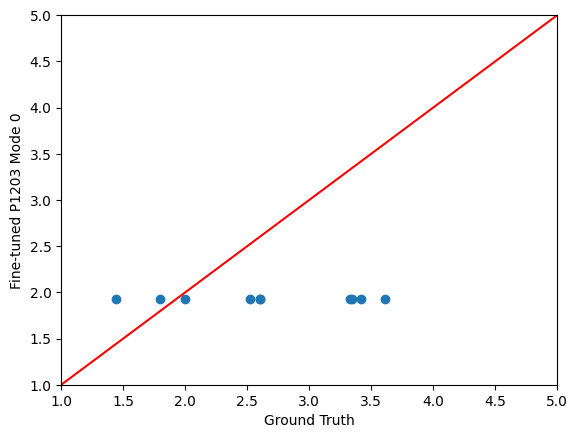

In [95]:
p1203_qoe_list = list(grouped_p1203_qoe['p1203_qoe'])
plt.scatter(ground_truth_qoe_list, p1203_qoe_list)
plt.plot([1, 5], [1, 5], color = 'red')
plt.axis([1, 5, 1, 5])
plt.xlabel("Ground Truth")
plt.ylabel("Fine-tuned P1203 Mode 0")

Spearmann
              Ground truth  P.1203
Ground truth           1.0     NaN
P.1203                 NaN     NaN
(2, 2)
nan


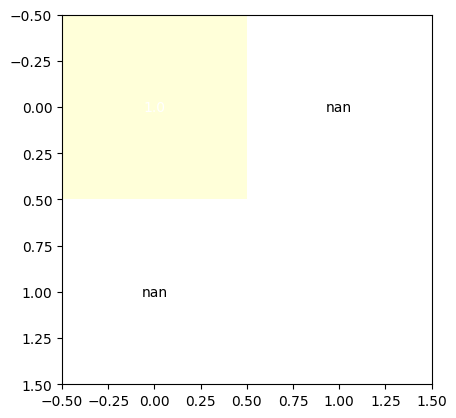

Pearson
              Ground truth  P.1203
Ground truth           1.0     NaN
P.1203                 NaN     NaN


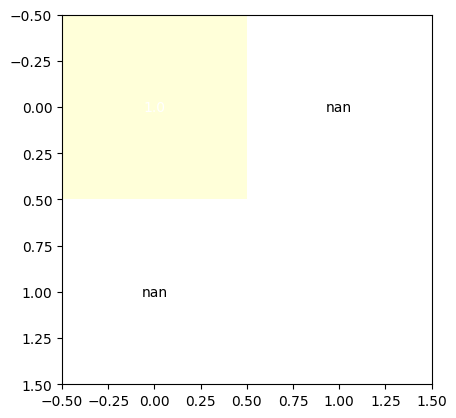

In [96]:
#import seaborn as sns

df_correlation = pd.DataFrame({
    "Ground truth": ground_truth_qoe_list,
    "P.1203": p1203_qoe_list
})

#corr_method = 'spearman'
#corr = df_correlation.corr(method=corr_method)
#sns.heatmap(corr, cmap='YlGnBu', annot = True)
#plt.savefig('./figures/correlation_heatmap_' + corr_method + '_optimized.pdf')
#plt.show()

spear_corr = df_correlation.corr(method = 'spearman') #pearson
print("Spearmann")
print(spear_corr)
print(spear_corr.shape)
print(spear_corr["Ground truth"]["P.1203"])

#sns.heatmap(corr, cmap='YlGnBu', annot = True)
plt.imshow(spear_corr, cmap='YlGnBu')

plt.text(0, 0, spear_corr['Ground truth']['Ground truth'], ha = "center", va = "center", color = "w")
plt.text(1, 0, spear_corr['Ground truth']['P.1203'], ha = "center", va = "center", color = "black")
plt.text(0, 1, spear_corr['P.1203']['Ground truth'], ha = "center", va = "center", color = "black")
plt.text(1, 1, spear_corr['P.1203']['P.1203'], ha = "center", va = "center", color = "w")


plt.savefig("./figures/correlation_spearman_optimized.pdf")
plt.show()

pearson_corr = df_correlation.corr(method = 'pearson') #spearman
print("Pearson")
print(pearson_corr)

#sns.heatmap(corr, cmap='YlGnBu', annot = True)
plt.imshow(pearson_corr, cmap='YlGnBu')

plt.text(0, 0, pearson_corr['Ground truth']['Ground truth'], ha = "center", va = "center", color = "w")
plt.text(1, 0, pearson_corr['Ground truth']['P.1203'], ha = "center", va = "center", color = "black")
plt.text(0, 1, pearson_corr['P.1203']['Ground truth'], ha = "center", va = "center", color = "black")
plt.text(1, 1, pearson_corr['P.1203']['P.1203'], ha = "center", va = "center", color = "w")


plt.savefig("./figures/correlation_pearson_optimized.pdf")
plt.show()


In [97]:
# corr_method = 'pearson'
# corr = df_correlation.corr(method=corr_method)
# sns.heatmap(corr, cmap='YlGnBu', annot = True)
# plt.savefig('./figures/correlation_heatmap_' + corr_method + '_optimized.pdf')
# plt.show()

In [98]:
#==============================================================================================================================
#VALIDATING with ReadyForWinter and FlowerDance

In [99]:
coeffs = {'u1': 72.61, 'u2': 0.32, 't1': 30.98, 't2': 1.29, 't3': 64.65, 'q1': 4.4, 'q2': -1.5, 'q3': 1.5, 'mode0': {'a1': 5, 'a2': -1.0, 'a3': 130, 'a4': 4.0}, 'mode1': {'a1': 5.00011566, 'a2': -1.19630824, 'a3': 41.3585049, 'a4': 0, 'c0': -0.91562479, 'c1': 0, 'c2': -3.28579526, 'c3': 20.4098663}, 'htv_1': -0.60293, 'htv_2': 2.12382, 'htv_3': -0.36936, 'htv_4': 0.03409}

qoe_p1203_dict = calculate_p1203(coeffs)
qoe_p1203_df = pd.DataFrame(qoe_p1203_dict)
qoe_p1203_df = qoe_p1203_df.loc[qoe_p1203_df['object'].isin(['ReadyForWinter', 'FlowerDance'])]
                                # & ((qoe_p1203_df['qual'].isin(['r01']) & qoe_p1203_df['end_quality'].isin(['r1'])) |
                                #  (qoe_p1203_df['start_quality'].isin(['r3']) & qoe_p1203_df['end_quality'].isin(['r3'])) |
                                #  (qoe_p1203_df['start_quality'].isin(['r5']) & qoe_p1203_df['end_quality'].isin(['r5']))) ]
qoe_validation = qoe_p1203_df.groupby(['object', 'qual']).mean()
qoe_validation

bitrate  p1203_qoe
object         qual                    
FlowerDance    r01      2.66   2.012671
               r02      4.24   2.373920
               r03      7.12   3.039299
               r04     22.81   3.525548
               r05     39.35   3.818253
ReadyForWinter r01      1.97   2.011076
               r02      2.58   2.367271
               r03      3.61   3.004307
               r04      9.34   3.501129
               r05     16.59   3.789382

In [100]:
# Get ground truth qoe for these sequences
ground_truth_qoe_df = df_vpcc_filtered.loc[df_vpcc_filtered['object'].isin(['ReadyForWinter', 'FlowerDance'])]
ground_truth_qoe_grouped_df = ground_truth_qoe_df.groupby(['object', 'qual']).aggregate(lambda x: tuple(x))
ground_truth_qoe_grouped_df

rate_scaled
object         qual                                                   
FlowerDance    r01   (1, 3, 2, 1, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 1, ...
               r02   (1, 3, 2, 2, 3, 3, 2, 1, 2, 2, 3, 3, 1, 3, 2, ...
               r03   (2, 4, 3, 2, 4, 3, 3, 3, 2, 2, 3, 3, 2, 3, 4, ...
               r04   (3, 4, 2, 3, 4, 3, 3, 4, 3, 3, 4, 3, 3, 3, 4, ...
               r05   (3, 5, 3, 3, 5, 4, 4, 3, 4, 4, 3, 4, 3, 4, 4, ...
ReadyForWinter r01   (1, 2, 2, 1, 2, 3, 1, 2, 1, 1, 2, 2, 1, 3, 1, ...
               r02   (2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...
               r03   (3, 3, 1, 3, 2, 3, 2, 2, 2, 3, 3, 2, 3, 3, 4, ...
               r04   (3, 4, 2, 3, 3, 3, 3, 4, 2, 4, 4, 4, 3, 3, 5, ...
               r05   (3, 4, 2, 4, 5, 4, 3, 4, 3, 3, 3, 4, 3, 4, 5, ...

In [101]:
calculate_rmse(qoe_validation, ground_truth_qoe_grouped_df)

np.float64(0.7122445125718814)

In [102]:
ground_truth_list = list(ground_truth_qoe_df.groupby(['object', 'qual']).mean()['rate_scaled'])
qoe_validation_list = list(qoe_validation['p1203_qoe'])
ground_truth_list

[1.7317073170731707,
 2.325,
 2.7948717948717947,
 3.3658536585365852,
 3.8048780487804876,
 1.6585365853658536,
 2.0,
 2.675,
 3.3902439024390243,
 3.725]

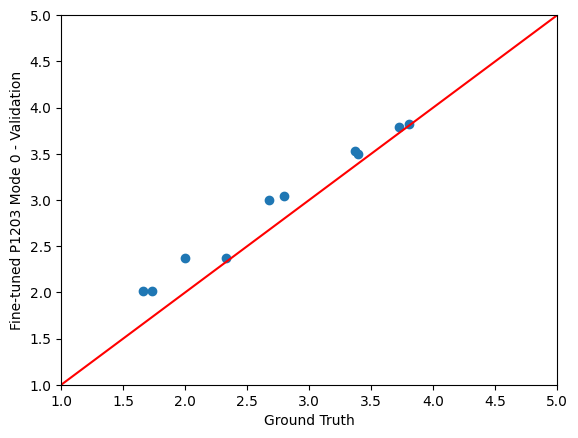

In [103]:
plt.scatter(ground_truth_list, qoe_validation_list)
plt.plot([1, 5], [1, 5], color='red')
plt.axis([1, 5, 1, 5])
plt.xlabel('Ground Truth')
plt.ylabel('Fine-tuned P1203 Mode 0 - Validation')
plt.show()

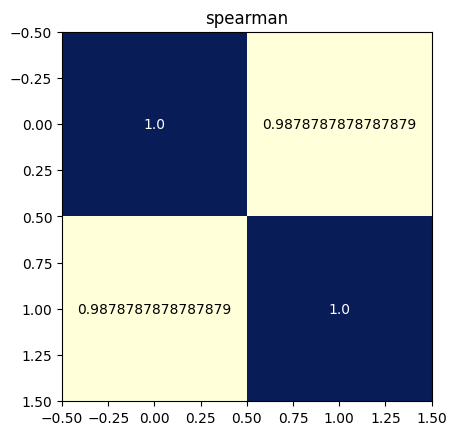

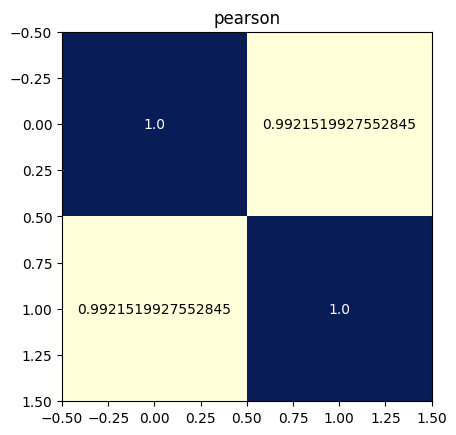

In [104]:
corr_method = 'spearman'
corr_df = pd.DataFrame({
    'Fine-tuned P1203': qoe_validation_list,
    'Ground truth': ground_truth_list
})

corr_methods = ['spearman', 'pearson']

for corr_method in corr_methods:
    corr = corr_df.corr(method=corr_method)
    #sns.heatmap(corr, cmap='YlGnBu', annot = True)
    plt.imshow(corr, cmap='YlGnBu')

    plt.text(0, 0, corr['Ground truth']['Ground truth'], ha = "center", va = "center", color = "w")
    plt.text(1, 0, corr['Ground truth']['Fine-tuned P1203'], ha = "center", va = "center", color = "black")
    plt.text(0, 1, corr['Fine-tuned P1203']['Ground truth'], ha = "center", va = "center", color = "black")
    plt.text(1, 1, corr['Fine-tuned P1203']['Fine-tuned P1203'], ha = "center", va = "center", color = "w")

    plt.savefig('./figures/correlation_heatmap_' + corr_method + '_validation.pdf')
    plt.title(corr_method)
    plt.show()

In [105]:
# original P1203
_COEFFS = {
        "u1": 72.61,
        "u2": 0.32,
        "t1": 30.98,
        "t2": 1.29,
        "t3": 64.65,
        "q1": 4.66,
        "q2": -0.07,
        "q3": 4.06,
        "mode0": {
            "a1": 11.9983519,
            "a2": -2.99991847,
            "a3": 41.2475074001,
            "a4": 0.13183165961,
        },
        "mode1": {
            "a1": 5.00011566,
            "a2": -1.19630824,
            "a3": 41.3585049,
            "a4": 0,
            "c0": -0.91562479,
            "c1": 0,
            "c2": -3.28579526,
            "c3": 20.4098663,
        },
        "htv_1": -0.60293,
        "htv_2": 2.12382,
        "htv_3": -0.36936,
        "htv_4": 0.03409,
    }

qoe_p1203_dict = calculate_p1203(_COEFFS)
qoe_p1203_df = pd.DataFrame(qoe_p1203_dict)
qoe_p1203_df = qoe_p1203_df.loc[qoe_p1203_df['object'].isin(['ReadyForWinter', 'FlowerDance'])]
                                #  & 
                                # ((qoe_p1203_df['start_quality'].isin(['r1']) & qoe_p1203_df['end_quality'].isin(['r1'])) |
                                #  (qoe_p1203_df['start_quality'].isin(['r3']) & qoe_p1203_df['end_quality'].isin(['r3'])) |
                                #  (qoe_p1203_df['start_quality'].isin(['r5']) & qoe_p1203_df['end_quality'].isin(['r5']))) ]
qoe_original_p1203 = qoe_p1203_df.groupby(['object', 'qual']).mean()
qoe_original_p1203

bitrate  p1203_qoe
object         qual                    
FlowerDance    r01      2.66   3.367212
               r02      4.24   4.185910
               r03      7.12   4.837059
               r04     22.81   4.886327
               r05     39.35   4.895940
ReadyForWinter r01      1.97   3.274671
               r02      2.58   4.036941
               r03      3.61   4.772641
               r04      9.34   4.865316
               r05     16.59   4.895940

In [106]:
print(calculate_rmse(qoe_original_p1203, ground_truth_qoe_grouped_df))
qoe_original_p1203_list = list(qoe_original_p1203['p1203_qoe'])

1.7974622597737144


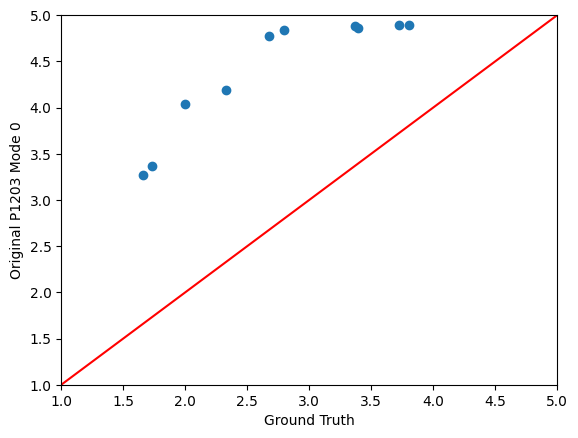

In [107]:
plt.scatter(ground_truth_list, qoe_original_p1203_list)
plt.plot([1, 5], [1, 5], color='red')
plt.axis([1, 5, 1, 5])
plt.xlabel('Ground Truth')
plt.ylabel('Original P1203 Mode 0')
plt.show()

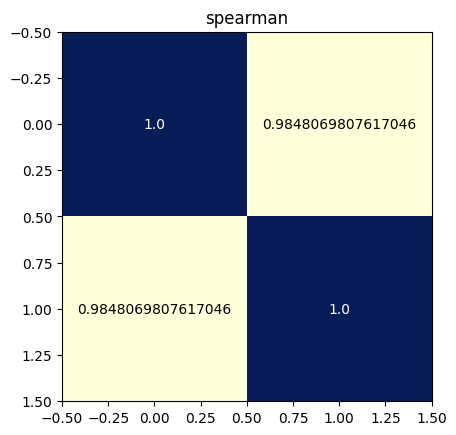

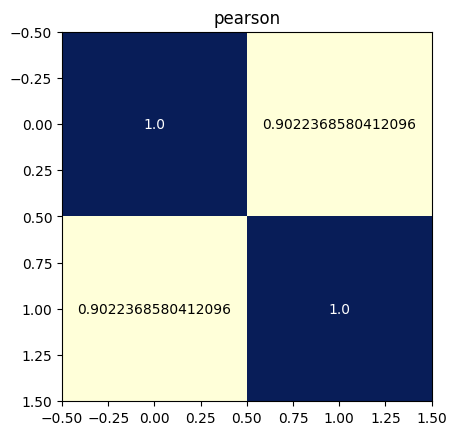

In [108]:
corr_all_df = pd.DataFrame({
    "Ground truth": ground_truth_list,
    # "Fine-tuned P1203": qoe_validation_list,
    "Original P1203": qoe_original_p1203_list
})

corr_methods = ['spearman', 'pearson']
for corr_method in corr_methods:
    corr = corr_all_df.corr(method=corr_method)
    #sns.heatmap(corr, cmap='YlGnBu', annot=True)
    plt.imshow(corr, cmap='YlGnBu')

    plt.text(0, 0, corr['Ground truth']['Ground truth'], ha = "center", va = "center", color = "w")
    plt.text(1, 0, corr['Ground truth']['Original P1203'], ha = "center", va = "center", color = "black")
    plt.text(0, 1, corr['Original P1203']['Ground truth'], ha = "center", va = "center", color = "black")
    plt.text(1, 1, corr['Original P1203']['Original P1203'], ha = "center", va = "center", color = "w")
    
    plt.title(corr_method)
    plt.show()